In [ ]:
!pip install pyspark
!pip install elephas

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from pyspark import SparkContext
sc = SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from elephas.utils.rdd_utils import to_simple_rdd

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
df = pd.read_csv("final_12m_18j.csv",parse_dates=True,index_col="Datetime")
df.columns = ['Negative','Neutral','Positive','Compound','Price']
df.head()

,Negative,Neutral,Positive,Compound,Price
Datetime,,,,,
2021-05-11 16:00:00,0.034933,0.896525,0.068540,0.078395,4051.436523
2021-05-11 16:15:00,0.035318,0.891431,0.073250,0.091189,4052.093994
2021-05-11 16:30:00,0.031698,0.900070,0.068225,0.087727,4025.809326
2021-05-11 16:45:00,0.025198,0.908028,0.066769,0.098010,4012.297852
2021-05-11 17:00:00,0.033684,0.896645,0.069674,0.086334,4023.643311


In [6]:
# df.set_index('DateTime',inplace=True)  #making DateTime as index. Because we are doing Time series Analysis
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
df = df[cols]
df.head()

,Price,Negative,Neutral,Positive,Compound
Datetime,,,,,
2021-05-11 16:00:00,4051.436523,0.034933,0.896525,0.068540,0.078395
2021-05-11 16:15:00,4052.093994,0.035318,0.891431,0.073250,0.091189
2021-05-11 16:30:00,4025.809326,0.031698,0.900070,0.068225,0.087727
2021-05-11 16:45:00,4012.297852,0.025198,0.908028,0.066769,0.098010
2021-05-11 17:00:00,4023.643311,0.033684,0.896645,0.069674,0.086334


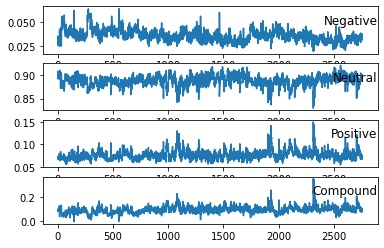

In [7]:
values = df.values
# specify columns to plot
groups = [1,2,3,4]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling values from 0 to 1
scaled = scaler.fit_transform(df.values)

n_hours = 3
n_features = 5              
n_obs = n_hours*n_features

reframed = series_to_supervised(scaled, n_hours, 1)  #t-3,t-2,t-1 values of all the columns. you can change n_hours for this
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.928272,0.349900,0.737697,0.148161,0.240381,0.928536,0.358200,0.681606,0.197597,0.275955,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567,0.139735,0.864348,0.129567,0.294918
4,0.928536,0.358200,0.681606,0.197597,0.275955,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119,0.322923,0.739008,0.160065,0.262453
5,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237,0.248839,0.784176,0.152988,0.282990
6,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237,0.248839,0.784176,0.152988,0.282990,0.922674,0.181679,0.820174,0.151382,0.321452
7,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237,0.248839,0.784176,0.152988,0.282990,0.922674,0.181679,0.820174,0.151382,0.321452,0.923789,0.141323,0.812793,0.177970,0.327153


In [9]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)  #dropping all the present values except present price
reframed.head()  #Note: here last column is present price which is our target variable

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.928272,0.349900,0.737697,0.148161,0.240381,0.928536,0.358200,0.681606,0.197597,0.275955,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567
4,0.928536,0.358200,0.681606,0.197597,0.275955,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119
5,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237
6,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237,0.248839,0.784176,0.152988,0.282990,0.922674
7,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237,0.248839,0.784176,0.152988,0.282990,0.922674,0.181679,0.820174,0.151382,0.321452,0.923789


In [10]:
cols = reframed.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
reframed = reframed[cols]
reframed.head()

,var1(t),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
3,0.912567,0.928272,0.349900,0.737697,0.148161,0.240381,0.928536,0.358200,0.681606,0.197597,0.275955,0.917988,0.280050,0.776726,0.144849,0.266328
4,0.917119,0.928536,0.358200,0.681606,0.197597,0.275955,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567,0.139735,0.864348,0.129567,0.294918
5,0.920237,0.917988,0.280050,0.776726,0.144849,0.266328,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119,0.322923,0.739008,0.160065,0.262453
6,0.922674,0.912567,0.139735,0.864348,0.129567,0.294918,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237,0.248839,0.784176,0.152988,0.282990
7,0.923789,0.917119,0.322923,0.739008,0.160065,0.262453,0.920237,0.248839,0.784176,0.152988,0.282990,0.922674,0.181679,0.820174,0.151382,0.321452


In [11]:
from pyspark.ml.linalg import Vectors
reg_DF =sql.createDataFrame(reframed)
ad_df = reg_DF.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])
ad_df.show(5)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[0.92827176663162...| 0.912566753822456|
|[0.92853558730342...| 0.917119299281163|
|[0.91798844717123...| 0.920237142703145|
|[0.91256675382245...|0.9226744215565215|
|[0.91711929928116...|0.9237886786896827|
+--------------------+------------------+
only showing top 5 rows



In [12]:
from pyspark.ml.regression import RandomForestRegressor

In [13]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'label')

In [14]:
rf = rf.fit(ad_df)

In [15]:
predictions = rf.transform(ad_df)
someDF = predictions.select("prediction", "label").show(5)

+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|0.9067462897298773| 0.912566753822456|
|0.9057720816651493| 0.917119299281163|
|0.8859136875513458| 0.920237142703145|
|0.9053969882407948|0.9226744215565215|
|0.9104648642554002|0.9237886786896827|
+------------------+------------------+
only showing top 5 rows



In [16]:
predictions = predictions.toPandas().head()

In [17]:
print(predictions)

                                            features     label  prediction
0  [0.9282717666316229, 0.3499004392394658, 0.737...  0.912567    0.906746
1  [0.9285355873034249, 0.35820035119284765, 0.68...  0.917119    0.905772
2  [0.9179884471712343, 0.2800496228620397, 0.776...  0.920237    0.885914
3  [0.912566753822456, 0.13973516133606823, 0.864...  0.922674    0.905397
4  [0.917119299281163, 0.32292305226603857, 0.739...  0.923789    0.910465


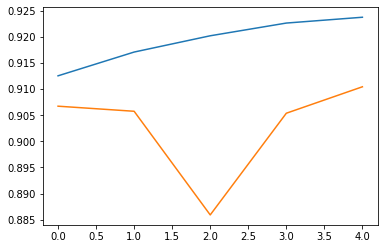

In [18]:
plt.plot(predictions['label'])
plt.plot(predictions['prediction'])
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
mean_absolute_error(predictions['label'],predictions['prediction'])

0.01641847692208016

In [21]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [22]:
mean_absolute_percentage_error(predictions['label'],predictions['prediction'])  # 3.5628748173204707. early 

1.7839536512050336

In [23]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

In [24]:
lr_model = lr.fit(ad_df)
predictions = lr_model.transform(ad_df)
someDF = predictions.select("prediction", "label").show(5)

+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|0.9163436415799076| 0.912566753822456|
|0.9106565921464493| 0.917119299281163|
|0.9159394471861058| 0.920237142703145|
|0.9180853324648346|0.9226744215565215|
|0.9212068494180194|0.9237886786896827|
+------------------+------------------+
only showing top 5 rows



In [25]:
predictions = predictions.toPandas().head()

In [26]:
print(predictions)

                                            features     label  prediction
0  [0.9282717666316229, 0.3499004392394658, 0.737...  0.912567    0.916344
1  [0.9285355873034249, 0.35820035119284765, 0.68...  0.917119    0.910657
2  [0.9179884471712343, 0.2800496228620397, 0.776...  0.920237    0.915939
3  [0.912566753822456, 0.13973516133606823, 0.864...  0.922674    0.918085
4  [0.917119299281163, 0.32292305226603857, 0.739...  0.923789    0.921207


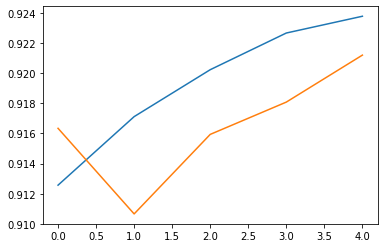

In [27]:
plt.plot(predictions['label'])
plt.plot(predictions['prediction'])
plt.show()

In [28]:
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

Coefficients: [-0.05189396247595009,-0.2864292735195359,-0.5825791797032374,-0.6284548204567453,0.024073068533002367,0.07809678400569113,0.21496876032425247,0.43608380008531,0.4625131116179601,-0.010272180973172474,0.9701630766368654,0.4264336918846216,0.8380145636501909,0.8812504761748452,-0.006546840438722245]
Intercept: -0.7403155051362302


In [29]:
mean_absolute_error(predictions['label'],predictions['prediction'])

0.004341641754510928

In [30]:
mean_absolute_percentage_error(predictions['label'],predictions['prediction'])

0.4724842342903416